# Talent Squad III
## Data Science
Juan Sirai

<img src="https://elearning.uq.edu.au/files/96561/exam-info-banner.jpg">

----------------------------------------------------------------------------

## Influences on Academic Performance

A study has been carried out to see if the academic performance of children is influenced by the academic level of their parents. Therefore, the academic results of the students will be evaluated based on several variables

## Features

* gender: Student's sex
* parental level of education: Educational level of the father
* lunch: If you have dining scholarships
* test preparation course: Attend academy
* math score: Math score
* reading score: Reading Comprehension
* writing score: Writing score

## Task

In this challenge you will have to predict if the student's academic results are influenced by the educational level of the parents. These have a number that represents the following educational level:
* high school: 0,
* some high school: 1,
* some college: 2,
* associate's degree: 3,
* bachelor's degree: 4,
* master's degree: 5

------------------------------------------------------------------------

In [162]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import f_oneway

from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score

from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
sns.set(style="ticks")
plt.style.use("dark_background")

# EDA

In [2]:
df = pd.read_csv('Data/train.csv')

In [3]:
df.head(2)

,Unnamed: 0,gender,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,764,female,1,standard,none,62,76,67
1,866,male,4,standard,none,79,57,58


In [4]:
df.isnull().sum()

Unnamed: 0                     0
gender                         0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [5]:
df['average_score'] = (df['math score'] + df['reading score'] + df['writing score'] )/ 3

## a) Scores Distribution

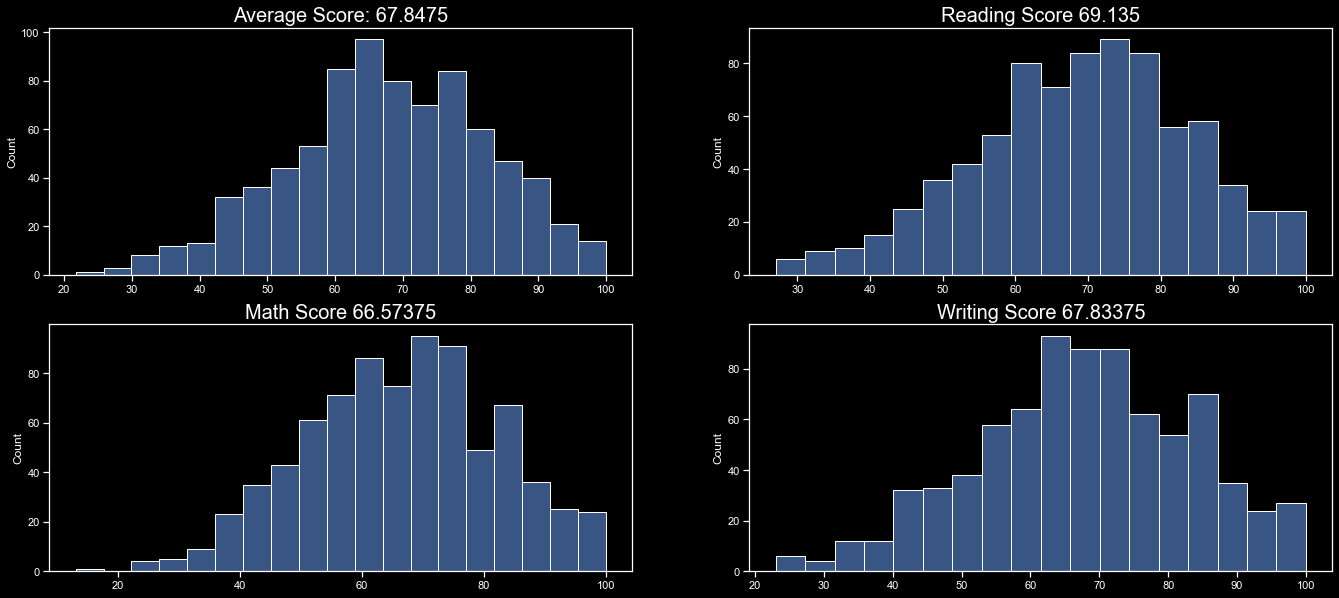

In [6]:
fig, axis=plt.subplots(2,2,figsize=(23,10))

axis[0,0].set_title(f"Average Score: {df['average_score'].mean()}", size=20)
b1 = sns.histplot(x=df['average_score'], ax = axis[0,0]).set(xlabel=None)


axis[1,0].set_title(f"Math Score {df['math score'].mean()}", size=20)
b1 = sns.histplot(x=df['math score'], ax = axis[1,0]).set(xlabel=None)

axis[0,1].set_title(f"Reading Score {df['reading score'].mean()}", size=20)
b1 = sns.histplot(x=df['reading score'], ax = axis[0,1]).set(xlabel=None)

axis[1,1].set_title(f"Writing Score {df['writing score'].mean()}", size=20)
b1 = sns.histplot(x=df['writing score'], ax = axis[1,1]).set(xlabel=None)



## b) Parental Education Distribution

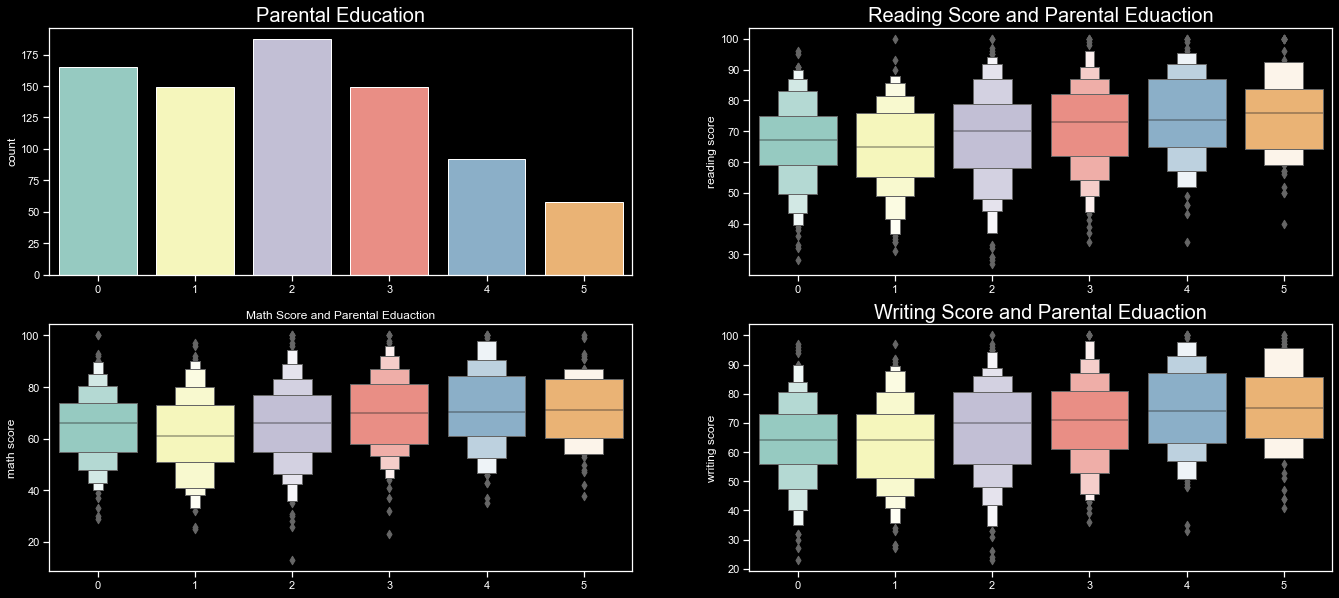

In [7]:
fig, axis=plt.subplots(2,2,figsize=(23,10))

axis[0,0].set_title("Parental Education", size=20)
b1 = sns.countplot(x=df['parental level of education'], ax = axis[0,0]).set(xlabel=None)


axis[1,0].set_title(f"Math Score and Parental Eduaction")
b1 = sns.boxenplot(x=df['parental level of education'],y=df['math score'], ax = axis[1,0]).set(xlabel=None)

axis[0,1].set_title(f"Reading Score and Parental Eduaction", size=20)
b1 = sns.boxenplot(x=df['parental level of education'],y=df['reading score'], ax = axis[0,1]).set(xlabel=None)

axis[1,1].set_title(f"Writing Score and Parental Eduaction", size=20)
b1 = sns.boxenplot(x=df['parental level of education'],y=df['writing score'], ax = axis[1,1]).set(xlabel=None)

As we can see, we have an inbalanced dataset, with less records at values 4 and 5 for parental education

If we look at the boxplots, the median for exam scores is higher as we grow in the educational level of the parentsr 

## c) Correlation Matrix

<AxesSubplot:>

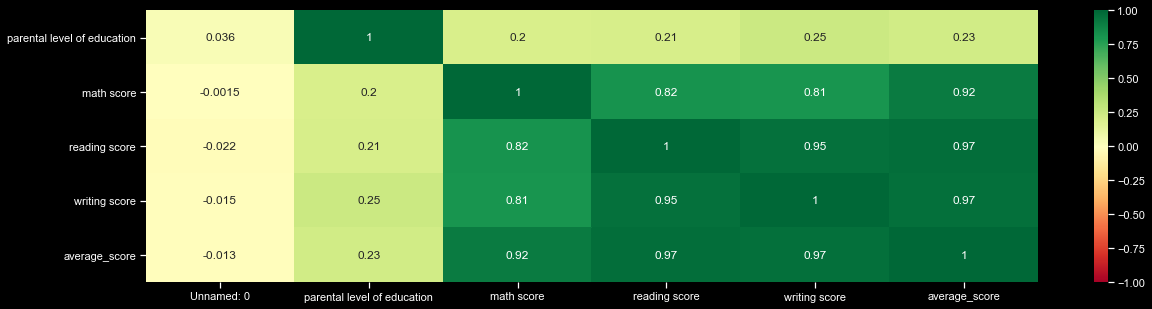

In [8]:
plt.figure(figsize=(20,5))
sns.heatmap(df.corr().drop('Unnamed: 0'), annot=True, vmin=-1, vmax=1, cmap="RdYlGn")

## d) Scatter Plot

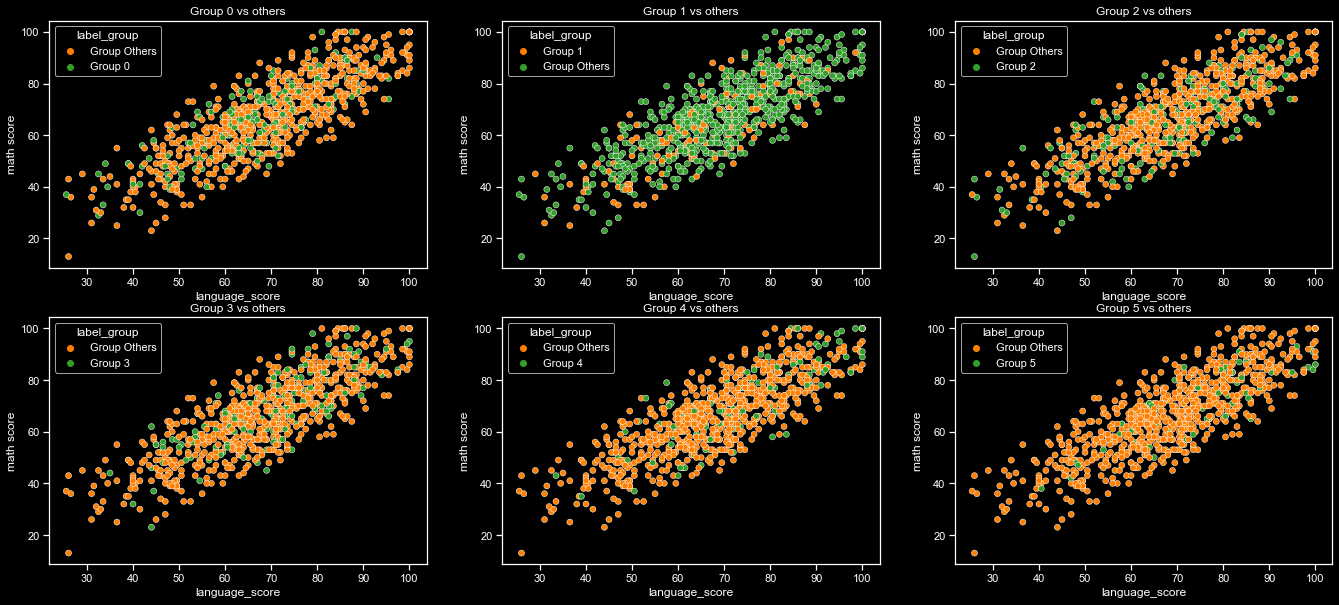

In [9]:
fig, axis=plt.subplots(2,3,figsize=(23,10))

col = 0
row = 0
group = 0
df2 = df.copy()
df2['language_score'] = (df2['reading score'] + df2['writing score']) / 2
while (row<2): 

    df2['label_group'] = df2['parental level of education'].apply(lambda x: f"Group {group}" if x==group else "Group Others")
    
    axis[row,col].set_title(f"Group {group} vs others")
    b1 = sns.scatterplot(x=df2['language_score'],y=df2['math score'],ax = axis[row,col], hue=df2['label_group'], palette='Paired_r')
    
    if(col<2):
        col+=1
    else:
        col=0
        row+=1
    group+=1

For the moment, we cannot identify clusters based on parental education.

We are going to make a little more deepdive in order to see each group

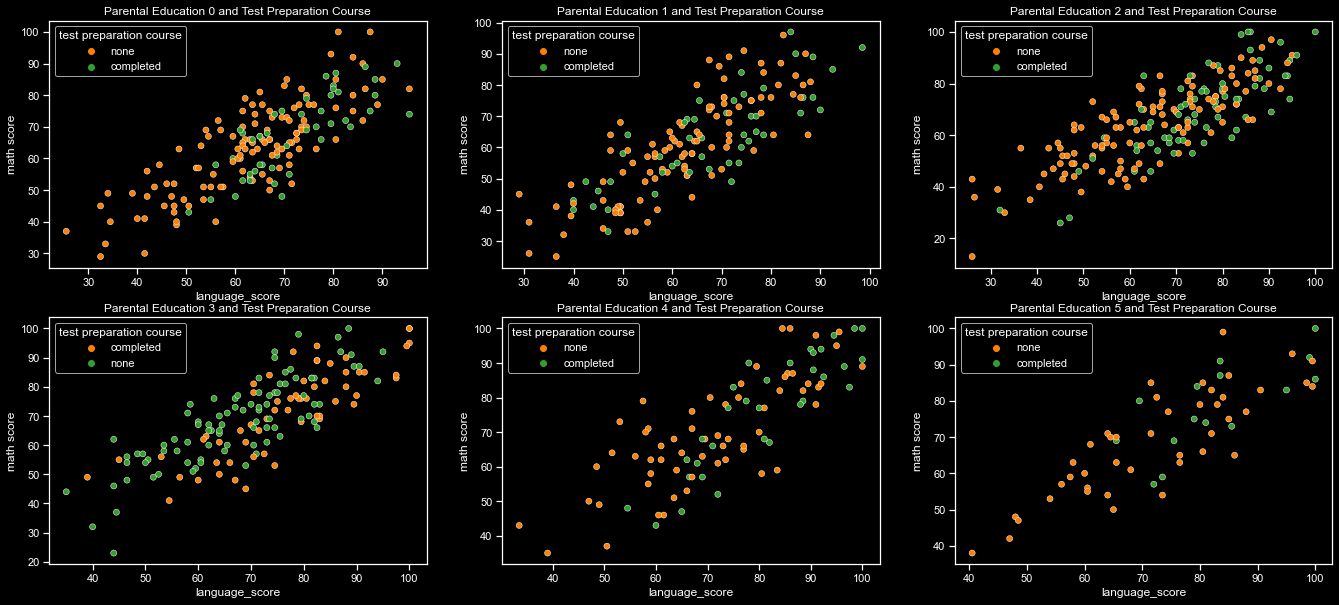

In [11]:
fig, axis=plt.subplots(2,3,figsize=(23,10))

col = 0
row = 0
group = 0

while (row<2):
    df2 = df.copy()
    df2['language_score'] = (df2['reading score'] + df2['writing score']) / 2
    df2 = df2.loc[df2['parental level of education']==group]
   
    axis[row,col].set_title(f"Parental Education {group} and Test Preparation Course")
    b1 = sns.scatterplot(x=df2['language_score'],y=df2['math score'],ax = axis[row,col],  palette='Paired_r', hue=df2['test preparation course'])
    
    if(col<2):
        col+=1
    else:
        col=0
        row+=1
    group+=1

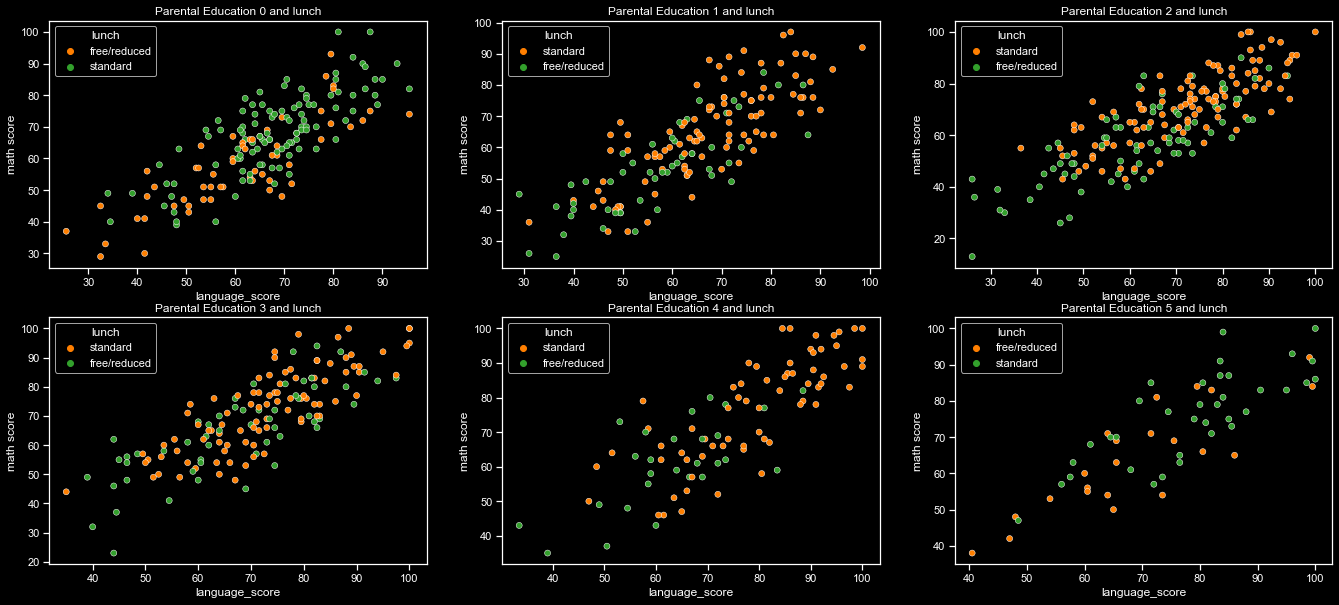

In [12]:
fig, axis=plt.subplots(2,3,figsize=(23,10))

col = 0
row = 0
group = 0

while (row<2):
    df2 = df.copy()
    df2['language_score'] = (df2['reading score'] + df2['writing score']) / 2
    df2 = df2.loc[df2['parental level of education']==group]
   
    axis[row,col].set_title(f"Parental Education {group} and lunch")
    b1 = sns.scatterplot(x=df2['language_score'],y=df2['math score'],ax = axis[row,col],  palette='Paired_r', hue=df2['lunch'])
    
    if(col<2):
        col+=1
    else:
        col=0
        row+=1
    group+=1

## e) Average Score and Other features

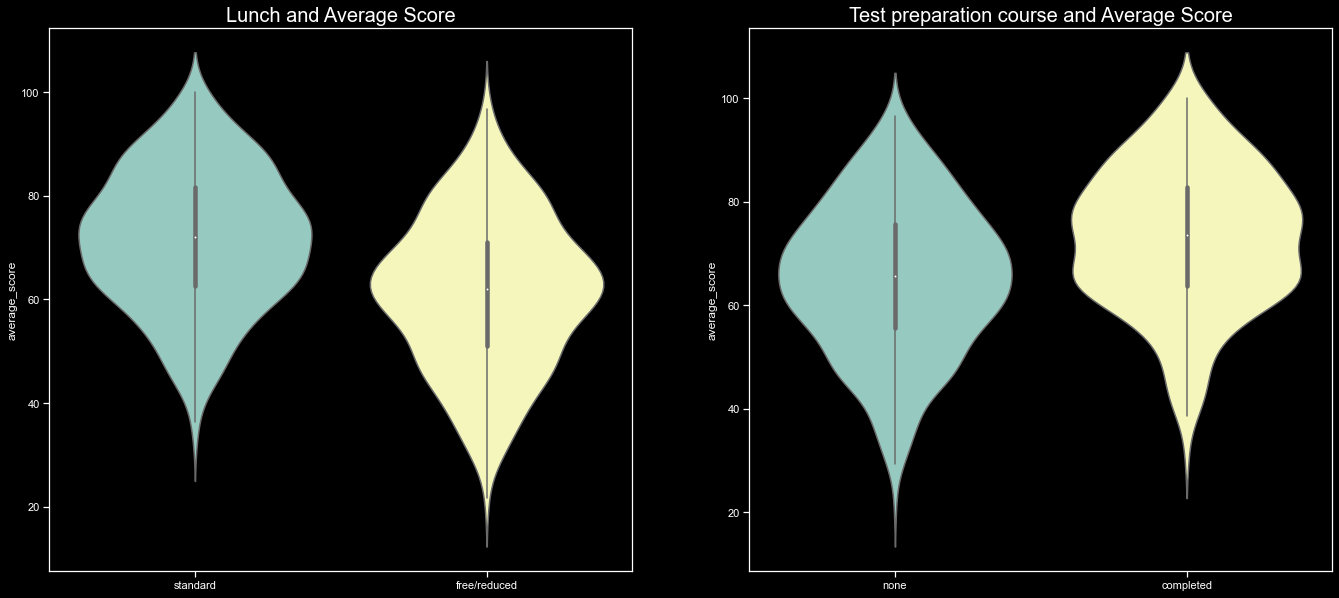

In [13]:
fig, axis=plt.subplots(1,2,figsize=(23,10))

axis[0].set_title("Lunch and Average Score", size=20)
b1 = sns.violinplot(x=df['lunch'],y=df['average_score'] ,ax = axis[0]).set(xlabel=None)


axis[1].set_title(f"Test preparation course and Average Score",size=20)
b1 = sns.violinplot(x=df['test preparation course'],y=df['average_score'], ax = axis[1]).set(xlabel=None)


We have some difference in the median, if we pay attention to those who completed the previous course.

--------------------------------------------------------------------------------------------------------------------

# ANOVA test

One-Way ANOVA in Python: One-way ANOVA (also known as “analysis of variance”) is a test that is used to find out whether there exists a statistically significant difference between the mean values of more than one group.

Hypothesis involved:
A one-way ANOVA has the below given null and alternative hypotheses:

* H0 (null hypothesis): μ1 = μ2 = μ3 = … = μk (It implies that the means of all the population are equal
* H1 (null hypothesis): It states that there will be at least one population mean that differs from the rest

**In this particular case, we are going to evaluate if there are significant differences between the average score means of each "parental education" group.**

### Step 1: Creating data groups.


In [15]:
df['parental level of education'].value_counts()

2    187
0    165
3    149
1    149
4     92
5     58
Name: parental level of education, dtype: int64

In [21]:
# Since our groups are not equally distributed, we will keep a sample of each one, equals to quantity of observations for group5 (58)

group_1=df.loc[df['parental level of education']==1,'average_score'].values[:58]
group_2=df.loc[df['parental level of education']==2,'average_score'].values[:58]
group_3=df.loc[df['parental level of education']==3,'average_score'].values[:58]
group_4=df.loc[df['parental level of education']==4,'average_score'].values[:58]
group_5=df.loc[df['parental level of education']==5,'average_score'].values

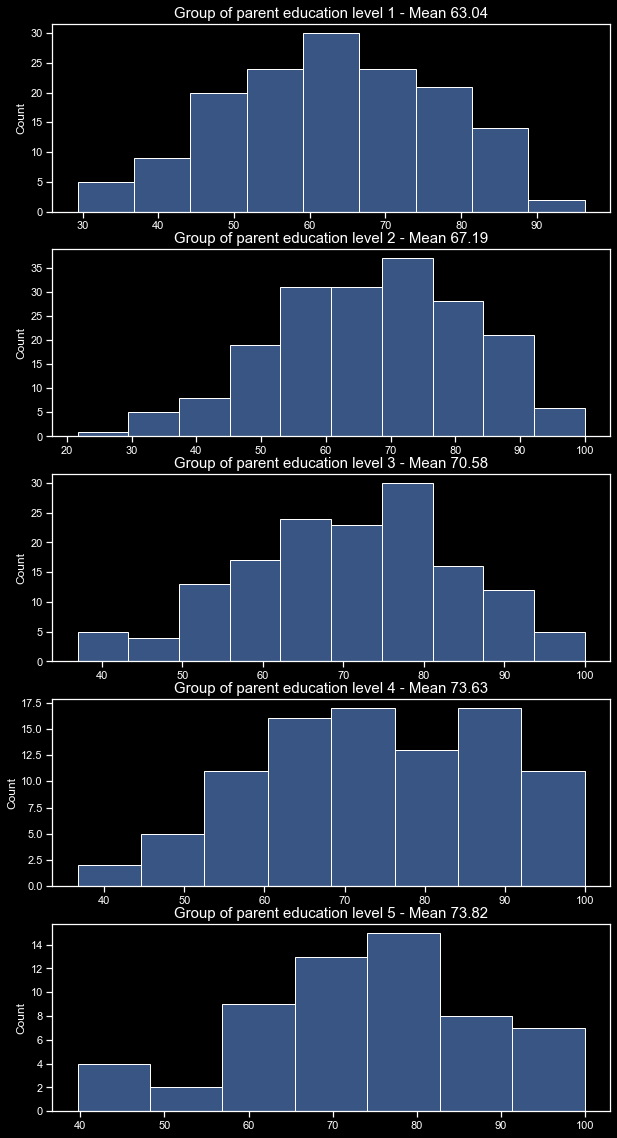

In [22]:
fig, axis=plt.subplots(5,1,figsize=(10,20))
for i in range(1,6):
    axis[i-1].set_title(f"Group of parent education level {i} - Mean {df.loc[df['parental level of education']==i,'average_score'].mean().round(2)}", size=15)
    b1 = sns.histplot(df.loc[df['parental level of education']==i,'average_score'].values ,ax = axis[i-1]).set(xlabel=None)

### Step 2: Conduct the one-way ANOVA

In [23]:
statistics = f_oneway(group_1, group_2, group_3, group_4, group_5)[0].round(3)
pvalue= f_oneway(group_1, group_2, group_3, group_4, group_5)[1].round(3)

In [24]:
print(f"The F statistic and p-value turn out to be equal to {statistics} and {pvalue} respectively. Since the p-value is less than 0.05 hence we would reject the null hypothesis. This implies that we have sufficient proof to say that there exists a difference in the performance of students, depends of parental education level") 

The F statistic and p-value turn out to be equal to 5.171 and 0.0 respectively. Since the p-value is less than 0.05 hence we would reject the null hypothesis. This implies that we have sufficient proof to say that there exists a difference in the performance of students, depends of parental education level


-----------------------------

# Testing Models

In [30]:
# we are going to drop the index, since is not relevant for our analysis
df = pd.read_csv('Data/train.csv').drop(columns = 'Unnamed: 0')

In [31]:
X = df.drop(columns='parental level of education')
y = df['parental level of education']

In [36]:
X_dummies = pd.get_dummies(X).drop(columns=['gender_male', 'lunch_free/reduced','test preparation course_none'])  # Creating dummies for categorical variables

## Testing with variations of the same dataset

In order to standarize the training of previous models, we are going to define a function which recives a dataset, and passes it through all those models, in order to get our scores

In [153]:
def evaluate_dataset(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    results = pd.DataFrame(columns=['Model', 'f1_train', 'f1_test'])
    
    
    # ----------------------- CLF Oversampled
    oversample = SMOTE()
    X_train_os, y_train_os = oversample.fit_resample(X_train, y_train)
    
    scaler = StandardScaler()
    X_train_os_sc = scaler.fit_transform(X_train_os, y_train_os)
    X_test_sc = scaler.transform(X_test)
    
    clf_pruned_os = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=5)
    clf_pruned_os.fit(X_train_os_sc, y_train_os)
    results = results.append({'Model' : 'CLF Oversampled', 
                              'f1_train' :f1_score(y_train_os, clf_pruned_os.predict(X_train_os_sc),average='macro'),
                              'f1_test' :f1_score(y_test, clf_pruned_os.predict(X_test_sc),average='macro')},
              ignore_index = True)
    
    
    # --------------------- RANDOM FOREST
    random_forest = RandomForestClassifier(n_estimators = 700,
                                  random_state=0, max_features=3, max_depth=4).fit(X_train_os_sc, y_train_os)
    results = results.append({'Model' : 'Random Forest', 
                              'f1_train' :f1_score(y_train_os, random_forest.predict(X_train_os_sc), average='macro'),
                              'f1_test' :f1_score(y_test, random_forest.predict(X_test_sc), average='macro')},
                      ignore_index = True)
    
    # --------------------- ADA BOOST
    ab = AdaBoostClassifier(base_estimator=clf_pruned_os, n_estimators=700,random_state=1, learning_rate = 0.001)
    ab.fit(X_train_os_sc, y_train_os)
    results = results.append({'Model' : 'ADA Boost', 
                              'f1_train' :f1_score(y_train_os, ab.predict(X_train_os_sc), average='macro'),
                             'f1_test' :f1_score(y_test, ab.predict(X_test_sc), average='macro')},
        ignore_index = True)
    
    # --------------------- Gradient Boost
    gb = GradientBoostingClassifier(max_depth=3,max_features=3)
    gb.fit(X_train_os_sc, y_train_os)
    results = results.append({'Model' : 'Gradient Boost', 
                              'f1_train' :f1_score(y_train_os, gb.predict(X_train_os_sc), average='macro'),
                              'f1_test' :f1_score(y_test, gb.predict(X_test_sc), average='macro')},
        ignore_index = True)
    
    
    #-------------------- CAT BOOST
    cat = CatBoostClassifier(verbose=0, n_estimators=1000, loss_function='MultiClass', eval_metric='TotalF1', learning_rate = 0.001)
    cat.fit(X_train_os_sc, y_train_os)
    results = results.append({'Model' : 'CAT Boost', 
                              'f1_train' :f1_score(y_train_os, cat.predict(X_train_os_sc), average='macro'),
                             'f1_test' :f1_score(y_test, cat.predict(X_test_sc), average='macro')},
        ignore_index = True)

    # ------------------ XG Boost
    
    XGB = XGBClassifier(max_depth=3, n_estimators=500,learning_rate = 0.001 ,use_label_encoder=False,eval_metric = "mlogloss")
    XGB.fit(X_train_os_sc, y_train_os)
    results = results.append({'Model' : 'XG Boost',
                              'f1_train' :f1_score(y_train_os, XGB.predict(X_train_os_sc), average='macro'),
                             'f1_test' :f1_score(y_test, XGB.predict(X_test_sc), average='macro')},
        ignore_index = True)
    
    # ----------------- Multinomial Log Regression

    log = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=0.5)
    log.fit(X_train_os_sc, y_train_os)
    results = results.append({'Model' : 'Log Regression', 
                              'f1_train' :f1_score(y_train_os, log.predict(X_train_os_sc), average='macro'),
                             'f1_test' :f1_score(y_test, log.predict(X_test_sc), average='macro')},
        ignore_index = True)
    
    # ----------------- Neural Network

    clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train_os_sc, y_train_os)
    results = results.append({'Model' : 'Neural Network', 
                              'f1_train' :f1_score(y_train_os, clf.predict(X_train_os_sc), average='macro'),
                             'f1_test' :f1_score(y_test, clf.predict(X_test_sc), average='macro')},
        ignore_index = True)
    
    # ------------------KNN
    
    neigh = KNeighborsClassifier(n_neighbors=5).fit(X_train_os_sc, y_train_os)
    results = results.append({'Model' : 'KNN', 
                              'f1_train' :f1_score(y_train_os, neigh.predict(X_train_os_sc), average='macro'),
                             'f1_test' :f1_score(y_test, neigh.predict(X_test_sc), average='macro')},
        ignore_index = True)
    

    
    
    plt.figure(figsize=(20,7))
    sns.barplot(x='Model', y='f1_test', data = results.sort_values(by='f1_test'))
    return results

### A) Full dataset + Dummies

C:\Users\juans\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,Model,f1_train,f1_test
0,CLF Oversampled,0.238648,0.154949
1,Random Forest,0.451174,0.208045
2,ADA Boost,0.389111,0.216371
3,Gradient Boost,0.729906,0.207690
4,CAT Boost,0.401238,0.224133
5,XG Boost,0.377291,0.220546
6,Log Regression,0.251397,0.225461
7,Neural Network,0.384763,0.270181
8,KNN,0.555703,0.209631


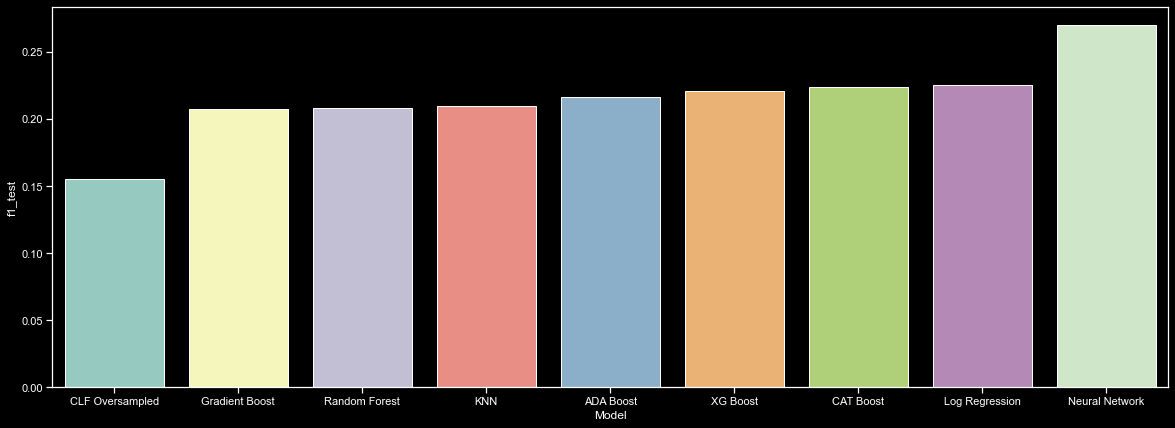

In [154]:
evaluate_dataset(X_dummies, y)

### B) Full dataset + Dummies + Average Score Column

In [155]:
df = pd.read_csv('Data/train.csv').drop(columns = 'Unnamed: 0')
df['average'] = (df['math score'] + df['reading score'] + df['writing score'] )/ 3

X = df.drop(columns='parental level of education')
y = df['parental level of education']

X_dummies_avg= pd.get_dummies(X).drop(columns=['gender_male', 'lunch_free/reduced','test preparation course_none'])  # Creating dummies for categorical variables



C:\Users\juans\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,Model,f1_train,f1_test
0,CLF Oversampled,0.246530,0.155980
1,Random Forest,0.442589,0.177387
2,ADA Boost,0.365608,0.213868
3,Gradient Boost,0.768844,0.165968
4,CAT Boost,0.391545,0.197542
5,XG Boost,0.372331,0.165201
6,Log Regression,0.279116,0.188063
7,Neural Network,0.388668,0.196936
8,KNN,0.543829,0.228883


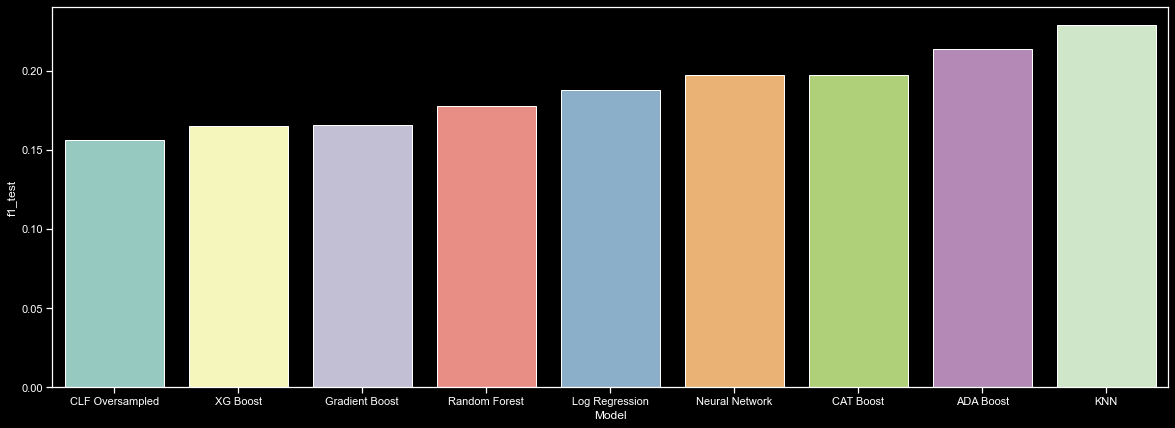

In [156]:
evaluate_dataset(X_dummies_avg, y)

### c) Only Scores features

In [157]:
df = pd.read_csv('Data/train.csv').drop(columns = ['Unnamed: 0','gender','lunch','test preparation course'])
df['average'] = (df['math score'] + df['reading score'] + df['writing score'] )/ 3


X = df.drop(columns=['parental level of education'])
y = df['parental level of education']

C:\Users\juans\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,Model,f1_train,f1_test
0,CLF Oversampled,0.271248,0.161668
1,Random Forest,0.394201,0.204538
2,ADA Boost,0.378877,0.205806
3,Gradient Boost,0.781959,0.194226
4,CAT Boost,0.308754,0.215293
5,XG Boost,0.362273,0.194284
6,Log Regression,0.241772,0.163163
7,Neural Network,0.295456,0.194359
8,KNN,0.536029,0.200687


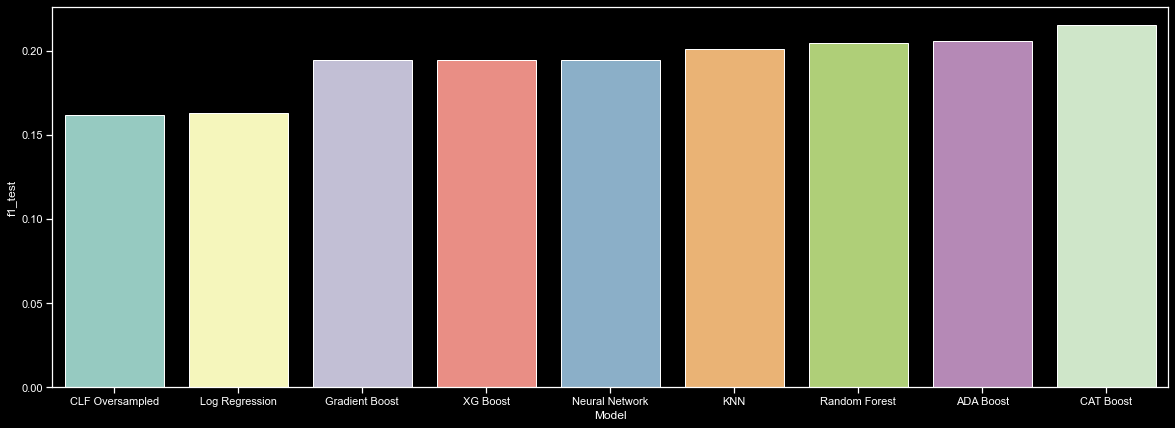

In [158]:
evaluate_dataset(X, y)

-------------------------

# Conclussion

Despite the fact that we did not obtain the desired results, the model that would seem to perform best is that of networks.

As future tests, we should test whether with different feature engineering we can obtain better results, but as we saw in the preliminary analysis, although the median differed between groups, they were homogeneously dispersed.

------------------------------------------------